<H1 style="text-align:center"> Slots Game Performance Predictor - Feed Forward model</H1>
<H2 style="text-align:center">Data Processing notebook</H2>

<br>

<p style="font-size:16px; font-family:Georgia;">The present notebook details the process of data extraction and data cleansing of the distribution information of different Slots Games' reward systems, in order to train a Neural Network model that predicts a game's success level (<strong>Successful</strong> or <strong>Unsuccessful</strong>).</p>

<h3>Game success definition</h3>

<p style="font-size:16px; font-family:Georgia;">A game's success level is measured by the ranking of the amount of bets during the first month after its release, as described in the below tableau report.</p>




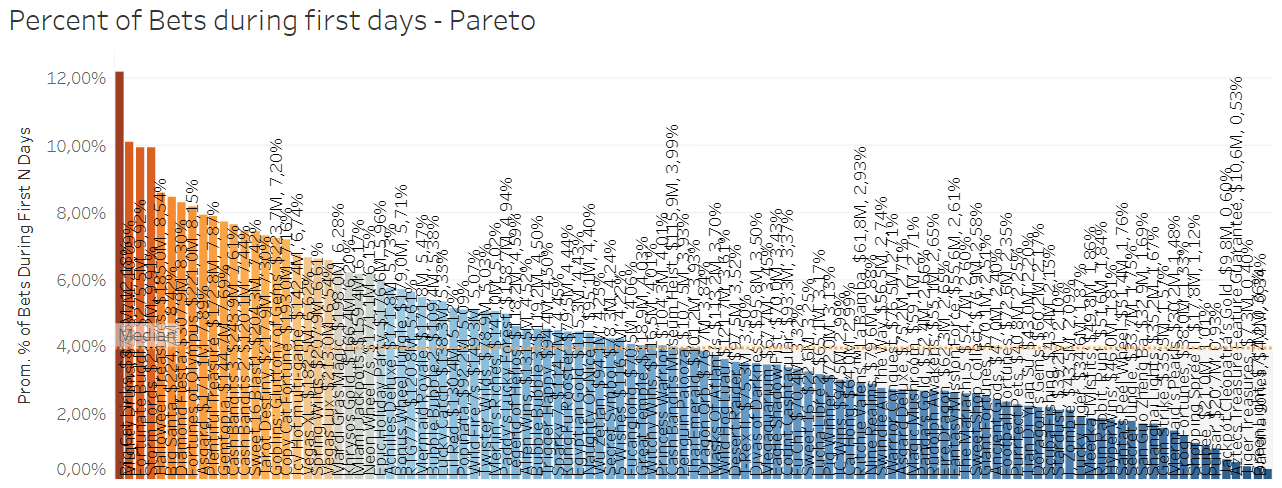

https://tableau-bi.realtimegaming.com/#/views/BetsDuringFirstNDaysafterGameActivation_0/ComparisonofBetsafterActivation?:iid=1



<p style="font-size:16px; font-family:Georgia;">In the table called math.Survival in the Hydra Database there is the information of the simulated spins of 162 games, from which, we extracted the top 9 best games and the worst 19 games:</p>

(358,307,250,362,254,299,363,268,347,245,315,221,236,
228,326,290,259,227,308,306,235,239,325,237,194,249,238,335,359,252)


<table style="width:100%;  align: initial;">
<tr>
<th style="text-align: center;font-size:16px;"> Top 9 best Slots Games </th>
<th style="text-align: center;font-size:16px;"> Top 19  worst Slots Games</th>
</tr>
<tr>
<td>
    
<li style="text-align:left;font-size:14px;">Mighty Drums (ID: 358)</li>
<li style="text-align:left;font-size:14px;">Fortunate Buddha (ID: 307)</li>
<li style="text-align:left;font-size:14px;">Storm Lords (ID: 250)</li>
<li style="text-align:left;font-size:14px;">Big Cat Links (ID: 362)</li>
<li style="text-align:left;font-size:14px;">Halloween Treasures (ID: 254)</li>
<li style="text-align:left;font-size:14px;">Big Santa	(ID: 299)</li>
<li style="text-align:left;font-size:14px;">Jackpot Saloon (ID: 363)</li>
<li style="text-align:left;font-size:14px;">Diamond Fiesta (ID: 268)</li>
<li style="text-align:left;font-size:14px;">Fortunes of Olympus (ID: 347)</li>

</td>
<td>

<li style="text-align:left;font-size:14px;">Mermaid Pearls (ID: 245)</li>
<li style="text-align:left;font-size:14px;">Gem Strike (ID: 315)</li>
<li style="text-align:left;font-size:14px;">Shanghai Lights (ID: 221) </li>
<li style="text-align:left;font-size:14px;">Three Kingdom Wars (ID: 236)</li>
<li style="text-align:left;font-size:14px;">Secret Jungle	(ID: 228)</li>
<li style="text-align:left;font-size:14px;">Santa's Reel Wheel (ID: 326)</li>
<li style="text-align:left;font-size:14px;">Hyper Wins (ID: 290)</li>
<li style="text-align:left;font-size:14px;">Run Rabbit Run (ID: 308) </li>
<li style="text-align:left;font-size:14px;">Meerkat Misfits (ID: 306)</li>
<li style="text-align:left;font-size:14px;">Stardust (ID: 235)</li>
<li style="text-align:left;font-size:14px;">Scuba Fishing	(ID: 239)</li>
<li style="text-align:left;font-size:14px;">Doragon's Gems (ID: 325)</li>
<li style="text-align:left;font-size:14px;">Gods Of Nature (ID: 237)</li>
<li style="text-align:left;font-size:14px;">Purrfect Pets	(ID: 194)</li>
<li style="text-align:left;font-size:14px;">Football Fortunes (ID: 249)</li>
<li style="text-align:left;font-size:14px;">Ancient Gods (ID: 238)</li>
<li style="text-align:left;font-size:14px;">Giant Fortunes (ID: 335)</li>
<li style="text-align:left;font-size:14px;">Sweet Shop Collect (ID: 359)</li>
<li style="text-align:left;font-size:14px;">The Mariachi 5 (ID: 252)</li>


</td>
</tr>
</table>




 
 



### Variable definition

<p style="font-size:16px; font-family:Georgia;"> The variables of the Slots Games' rewards that were considered to train the neural network model are 
<ul><li>PayOut (Base Win)</li>
<li>Feature PayOut (Feature Win)</li> 
<li>Balance </li> 
<li>Free Games </li> 
<li>Near Miss events </li> 
<li>Losses Disuised as Wins LDWs </li> 
<li>Losser Streaks </li> 
<li>Winning Streaks </li> 
<li>Distinct Pay Out </li> 
<li>Total Played Spins </li>
</ul></p>
<p style="font-size:16px; font-family:Georgia;">For each of these variables it was calculated their distribution (<em>max, min, average, standard deviation, median, mode, kurtosis, skewness, 25th percentile, 75th percentile</em>)</p>

# Libraries
required libraries for Data extraction and processing

In [1]:
import pyodbc
import pandas as pd
import numpy as np
from scipy.stats import norm, kurtosis
import math
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import BinaryFocalCrossentropy
from keras.layers import BatchNormalization
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from tensorflow import keras
from sklearn.feature_selection import VarianceThreshold

<h1 style="text-align:center"><u> 1 - Data Frame creation </u></h1>

In this section we extract the required data to construct the Data Frame that will used to train our Neural Network model.

## 1.1 - Obtaining Distribution for Pay Outs, Feature Pay Outs, Balance, Free Games and Near Misses

From the Hydra DB, we extract the data regarding the game session's pay outs, Feature Pay Outs, Balance, Free Games and Near Misses. We then calculate their respective distributions.



### Pulling Data from SQL


In [2]:
#We initiate the conecction string 
cnxn = pyodbc.connect('DRIVER={ODBC Driver 18 for SQL Server};Server=azurehydramanagerdb.database.windows.net;Port=1433;Database=Hydra;UID=racer_profiler;PWD=r@c3er_pro0f1l3er')


#We excecute our query and save the results into a local variable

cursor = cnxn.cursor()
cursor.execute('''select SequenceId, GutsId, SampleId, Balance, TotalBet, WinBase, WinFeature,
                FreeGamesWon, cast(Beyond100 as int) Beyond100, cast(IsNearMiss as int) IsNearMiss, WinLevelId

                FROM (  
                  SELECT *,  
                    ROW_NUMBER() OVER (PARTITION BY GutsId, SampleId ORDER BY SequenceId) AS row_num  
                  FROM math.Survival  
                  WHERE GutsId IN (/*358,307,250,362,254,299,363,268,347,

                                   245,315,221,236, 228,326,290,259,227,
                                   308,306,235,239,325,237,194,249,238,335,
                                   359,252*/
                                   
                                   191,232,272,197,316,341,
                                   227,259,351,220,319,224
                                  


                                  )
                ) subquery  
                WHERE row_num <= 800  -- <--- Select no. of spins per sample
                order by gutsid, SampleId,SequenceId
''')
records = cursor.fetchall()
cursor.close()

# #------------------------------------

# #We excecute our query and save the results into a local variable

# cursor = cnxn.cursor()
# cursor.execute('''select SequenceId, GutsId, SampleId, Balance, TotalBet, WinBase, WinFeature,
#                 FreeGamesWon, cast(Beyond100 as int) Beyond100, cast(IsNearMiss as int) IsNearMiss, WinLevelId

#                 FROM (  
#                   SELECT *,  
#                     ROW_NUMBER() OVER (PARTITION BY GutsId, SampleId ORDER BY SequenceId) AS row_num  
#                   FROM math.Survival  
#                   WHERE GutsId IN (
#                                   /*228,326,290,259,227,308,306,235,239,325,237,194,249,238,335,
#                                    359,252
#                                    ,222,234,226*/
                                   
#                                    319,224,230,282,244,225,219,309

#                                   )
#                 ) subquery  
#                 WHERE row_num <= 800  -- <------------------------ select no. of spins per sample
#                 order by gutsid, SampleId,SequenceId
# ''')
# records2 = cursor.fetchall()
# cursor.close()



We save the results into a pandas DataFrame before extracting their distribution values

In [3]:
recordsList=[]
for i in records:
    recordsList.append(tuple(i)) 
    
# for i in records2:
#     recordsList.append(tuple(i)) 

data_DF=pd.DataFrame(recordsList,columns=['SequenceId' ,'GutsId' ,'SampleId' ,'Balance' ,'TotalBet', 'WinBase', 'WinFeature', 'FreeGamesWon' ,'Beyond100' ,'IsNearMiss' ,'WinLevelId'])
data_DF


,SequenceId,GutsId,SampleId,Balance,TotalBet,WinBase,WinFeature,FreeGamesWon,Beyond100,IsNearMiss,WinLevelId
0,1,191,219671,90.00,0.90,0.90,0.00,0,0,0,2
1,2,191,219671,89.10,0.90,0.00,0.00,0,0,0,0
2,3,191,219671,90.00,0.90,1.80,0.00,0,0,0,3
3,4,191,219671,89.40,0.90,0.30,0.00,0,0,0,1
4,5,191,219671,88.50,0.90,0.00,0.00,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8965530,171,351,12014,4.00,1.00,0.00,0.00,0,1,0,0
8965531,172,351,12014,3.00,1.00,0.00,0.00,0,1,1,0
8965532,173,351,12014,2.00,1.00,0.00,0.00,0,1,0,0
8965533,174,351,12014,1.00,1.00,0.00,0.00,0,1,0,0


### Obtaining Distribution of Each Sample
Next, we group the data by GutsID and SampleId to extract the variables' distribution.

In [4]:
records_DF=data_DF.copy()
#We modify the win level Id
records_DF['WinLevelId'] = np.where(records_DF['WinLevelId'] == 0, 1, 0)  

#We change the data types of some variables
records_DF['WinBase']=records_DF['WinBase'].astype(float)
records_DF['WinFeature']=records_DF['WinFeature'].astype(float)
records_DF['Balance']=records_DF['Balance'].astype(float)

#We group the data frame by the GutsId amd SampleId and then apply operations to obtain different values of its distribution
Table_DF=pd.concat([records_DF.groupby(['GutsId', 'SampleId'])['WinBase'].min(), records_DF.groupby(['GutsId', 'SampleId'])['WinBase'].max(),
                    records_DF.groupby(['GutsId', 'SampleId'])['WinBase'].mean(), records_DF.groupby(['GutsId', 'SampleId'])['WinBase'].std(),
                    records_DF.groupby(['GutsId', 'SampleId'])['WinBase'].median(),records_DF.groupby(['GutsId', 'SampleId'])['WinBase'].agg(pd.Series.mode),
                    records_DF.groupby(['GutsId', 'SampleId'])['WinBase'].apply(pd.Series.kurt), records_DF.groupby(['GutsId', 'SampleId'])['WinBase'].skew(),
                    records_DF.groupby(['GutsId', 'SampleId'])['WinBase'].quantile('0.25'),records_DF.groupby(['GutsId', 'SampleId'])['WinBase'].quantile('0.75'),
                    
                    records_DF.groupby(['GutsId', 'SampleId'])['WinFeature'].min(), records_DF.groupby(['GutsId', 'SampleId'])['WinFeature'].max(),
                    records_DF.groupby(['GutsId', 'SampleId'])['WinFeature'].mean(), records_DF.groupby(['GutsId', 'SampleId'])['WinFeature'].std(),
                    records_DF.groupby(['GutsId', 'SampleId'])['WinFeature'].median(),records_DF.groupby(['GutsId', 'SampleId'])['WinFeature'].agg(pd.Series.mode),
                    records_DF.groupby(['GutsId', 'SampleId'])['WinFeature'].apply(pd.Series.kurt), records_DF.groupby(['GutsId', 'SampleId'])['WinFeature'].skew(),
                    records_DF.groupby(['GutsId', 'SampleId'])['WinFeature'].quantile('0.25'),records_DF.groupby(['GutsId', 'SampleId'])['WinFeature'].quantile('0.75'),
                    
                    records_DF.groupby(['GutsId', 'SampleId'])['Balance'].min(), records_DF.groupby(['GutsId', 'SampleId'])['Balance'].max(),
                    records_DF.groupby(['GutsId', 'SampleId'])['Balance'].mean(), records_DF.groupby(['GutsId', 'SampleId'])['Balance'].std(),
                    records_DF.groupby(['GutsId', 'SampleId'])['Balance'].median(),#records_DF.groupby(['GutsId', 'SampleId'])['Win'].agg(pd.Series.mode),
                    records_DF.groupby(['GutsId', 'SampleId'])['Balance'].apply(pd.Series.kurt), records_DF.groupby(['GutsId', 'SampleId'])['Balance'].skew(),
                    records_DF.groupby(['GutsId', 'SampleId'])['Balance'].quantile('0.25'),records_DF.groupby(['GutsId', 'SampleId'])['Balance'].quantile('0.75'),
                    
                    records_DF.groupby(['GutsId', 'SampleId'])['WinLevelId'].min(), records_DF.groupby(['GutsId', 'SampleId'])['WinLevelId'].max(),
                    records_DF.groupby(['GutsId', 'SampleId'])['WinLevelId'].mean(), records_DF.groupby(['GutsId', 'SampleId'])['WinLevelId'].std(),
                    records_DF.groupby(['GutsId', 'SampleId'])['WinLevelId'].median(),records_DF.groupby(['GutsId', 'SampleId'])['WinLevelId'].agg(pd.Series.mode),
                    records_DF.groupby(['GutsId', 'SampleId'])['WinLevelId'].apply(pd.Series.kurt), records_DF.groupby(['GutsId', 'SampleId'])['WinLevelId'].skew(),
                    records_DF.groupby(['GutsId', 'SampleId'])['WinLevelId'].quantile('0.25'),records_DF.groupby(['GutsId', 'SampleId'])['WinLevelId'].quantile('0.75'),
                    
                    
                    
                    #records_DF.groupby(['GutsId', 'SampleId'])['totalPlayedSpins'].mean(),
                    
                    records_DF.groupby(['GutsId', 'SampleId'])['FreeGamesWon'].min(), records_DF.groupby(['GutsId', 'SampleId'])['FreeGamesWon'].max(),
                    records_DF.groupby(['GutsId', 'SampleId'])['FreeGamesWon'].mean(), records_DF.groupby(['GutsId', 'SampleId'])['FreeGamesWon'].std(),
                    records_DF.groupby(['GutsId', 'SampleId'])['FreeGamesWon'].median(), records_DF.groupby(['GutsId', 'SampleId'])['FreeGamesWon'].agg(pd.Series.mode),
                    records_DF.groupby(['GutsId', 'SampleId'])['FreeGamesWon'].apply(pd.Series.kurt), records_DF.groupby(['GutsId', 'SampleId'])['FreeGamesWon'].skew(),
                    records_DF.groupby(['GutsId', 'SampleId'])['FreeGamesWon'].quantile('0.25'),records_DF.groupby(['GutsId', 'SampleId'])['FreeGamesWon'].quantile('0.75'),
                    
                    records_DF.groupby(['GutsId', 'SampleId'])['IsNearMiss'].min(), records_DF.groupby(['GutsId', 'SampleId'])['IsNearMiss'].max(),
                    records_DF.groupby(['GutsId', 'SampleId'])['IsNearMiss'].mean(), records_DF.groupby(['GutsId', 'SampleId'])['IsNearMiss'].std(),
                    records_DF.groupby(['GutsId', 'SampleId'])['IsNearMiss'].median(), records_DF.groupby(['GutsId', 'SampleId'])['IsNearMiss'].agg(pd.Series.mode),
                    records_DF.groupby(['GutsId', 'SampleId'])['IsNearMiss'].apply(pd.Series.kurt), records_DF.groupby(['GutsId', 'SampleId'])['IsNearMiss'].skew(),
                    records_DF.groupby(['GutsId', 'SampleId'])['IsNearMiss'].quantile('0.25'),records_DF.groupby(['GutsId', 'SampleId'])['IsNearMiss'].quantile('0.75')], axis=1)

Table_DF.columns=['min_PayOut','max_PayOut','avg_PayOut','std_PayOut','median_PayOut','mode_PayOut','krt_PayOut','skw_PayOut','25th_PayOut','75th_PayOut',
                  'min_WinFeature','max_WinFeature','avg_WinFeature','std_WinFeature','median_WinFeature','mode_WinFeature','krt_WinFeature','skw_WinFeature','25th_WinFeature','75th_WinFeature',
                  'min_Balance','max_Balance','avg_Balance','std_Balance','median_Balance','krt_Balance','skw_Balance','25th_Balance','75th_Balance',
                  
                  'min_WinLevel','max_WinLevel','avg_WinLevel','std_WinLevel','median_WinLevel', 'mode_WinLevel', 'krt_WinLevel','skw_WinLevel','25th_WinLevel','75th_WinLevel',

                  'min_FreeGames','max_FreeGames','avg_FreeGames','std_FreeGames','median_FreeGames','mode_FreeGames','krt_FreeGames','skw_FreeGames','25th_FreeGames','75th_FreeGames',
                  'min_NearMiss','max_NearMiss','avg_NearMiss','std_NearMiss','median_NearMiss','mode_NearMiss','krt_NearMiss', 'skw_NearMiss','25th_NearMiss','75th_NearMiss']
Table_DF

min_PayOut  max_PayOut  avg_PayOut  std_PayOut  \
GutsId SampleId                                                   
191    219671           0.0       22.50    0.612862    2.026624   
       219672           0.0       21.00    0.586950    1.893502   
       219673           0.0       12.84    0.571576    1.659182   
       219674           0.0       19.44    0.560100    1.759040   
       219675           0.0       11.25    0.543243    1.541721   
...                     ...         ...         ...         ...   
351    12009            0.0       97.00    0.818250    5.523727   
       12010            0.0        4.80    0.264706    0.757337   
       12011            0.0       96.00    0.748500    4.723445   
       12012            0.0       10.20    0.435359    1.173820   
       12014            0.0        6.60    0.362286    0.972114   

                 median_PayOut  mode_PayOut  krt_PayOut  skw_PayOut  \
GutsId SampleId                                                       
191    219671              0.0          0.0   56.711771    6.812945   
       219672              0.0          0.0   50.407456    6.458138   
       219673              0.0          0.0   24.285032    4.653674   
       219674              0.0          0.0   43.937970    5.867721   
       219675              0.0          0.0   25.270645    4.736724   
...                        ...          ...         ...         ...   
351    12009               0.0          0.0  235.469031   14.534814   
       12010               0.0          0.0   21.359690    4.360992   
       12011               0.0          0.0  261.849228   15.031623   
       12012               0.0          0.0   29.818033    4.754219   
       12014               0.0          0.0   14.973768    3.648255   

                 25th_PayOut  75th_PayOut  ...  min_NearMiss  max_NearMiss  \
GutsId SampleId                            ...                               
191    219671            0.0         0.30  ...             0             1   
       219672            0.0         0.36  ...             0             1   
       219673            0.0         0.30  ...             0             1   
       219674            0.0         0.30  ...             0             1   
       219675            0.0         0.39  ...             0             1   
...                      ...          ...  ...           ...           ...   
351    12009             0.0         0.20  ...             0             1   
       12010             0.0         0.20  ...             0             1   
       12011             0.0         0.20  ...             0             1   
       12012             0.0         0.20  ...             0             1   
       12014             0.0         0.20  ...             0             1   

                 avg_NearMiss  std_NearMiss  median_NearMiss  mode_NearMiss  \
GutsId SampleId                                                               
191    219671        0.041250      0.198992              0.0              0   
       219672        0.058750      0.235303              0.0              0   
       219673        0.032609      0.177771              0.0              0   
       219674        0.032500      0.177435              0.0              0   
       219675        0.073359      0.261230              0.0              0   
...                       ...           ...              ...            ...   
351    12009         0.041250      0.198992              0.0              0   
       12010         0.029412      0.169582              0.0              0   
       12011         0.035000      0.183895              0.0              0   
       12012         0.049724      0.217977              0.0              0   
       12014         0.022857      0.149877              0.0              0   

                 krt_NearMiss  skw_NearMiss  25th_NearMiss  75th_NearMiss  
GutsId SampleId                                                            
191    219671       19.414

## 1.2 - Obtaining Distribution for Distinct PayOut variable
We extract the unique values of all payouts in a game session and calculate its distribution.

In [5]:
distinctPay_list=[]
for i in data_DF['GutsId'].unique():
    for j in data_DF[data_DF['GutsId']==i]['SampleId'].unique():
        for k in data_DF[(data_DF['GutsId']==i)&(data_DF['SampleId']==j)]['WinBase'].drop_duplicates():
            distinctPay_list.append((i,j,k))

distinctPayOut_df=pd.DataFrame(distinctPay_list,columns=['GutsId' ,'SampleId','WinBase'])


In [6]:
distinctPayOut_df['WinBase']=distinctPayOut_df['WinBase'].astype(float)


dp_DF=pd.concat([distinctPayOut_df.groupby(['GutsId', 'SampleId'])['WinBase'].count(), 
                    distinctPayOut_df.groupby(['GutsId', 'SampleId'])['WinBase'].min(), distinctPayOut_df.groupby(['GutsId', 'SampleId'])['WinBase'].max(),
                    distinctPayOut_df.groupby(['GutsId', 'SampleId'])['WinBase'].mean(), distinctPayOut_df.groupby(['GutsId', 'SampleId'])['WinBase'].std(),
                    distinctPayOut_df.groupby(['GutsId', 'SampleId'])['WinBase'].median(),#distinctPayOut_df.groupby(['GutsId', 'SampleId'])['WinBase'].agg(pd.Series.mode),
                    distinctPayOut_df.groupby(['GutsId', 'SampleId'])['WinBase'].apply(pd.Series.kurt), distinctPayOut_df.groupby(['GutsId', 'SampleId'])['WinBase'].skew(),
                    distinctPayOut_df.groupby(['GutsId', 'SampleId'])['WinBase'].quantile('0.25'),distinctPayOut_df.groupby(['GutsId', 'SampleId'])['WinBase'].quantile('0.75')], axis=1)

dp_DF.columns=['count_distinctPayOut', 'min_distinctPayOut','max_distinctPayOut',
               'avg_distinctPayOut','std_distinctPayOut','median_distinctPayOut',#'mode_distinctPayOut',
               'krt_distinctPayOut','skw_distinctPayOut',
               '25th_distinctPayOut','75th_distinctPayOut']
# dp_DF


In [7]:
dp_DF.loc[dp_DF['krt_distinctPayOut'].isna(),'krt_distinctPayOut']=0
dp_DF.loc[dp_DF['skw_distinctPayOut'].isna(),'skw_distinctPayOut']=0

## 1.3 - Losses Disguised as Wins
We calculate the Losses Disguised as Winnings distribution.

In [8]:
LDWs_=data_DF[['GutsId', 'SampleId','WinLevelId']].copy()
LDWs_['LDW']=0

LDWs_.loc[(LDWs_['WinLevelId']==1), 'LDW'] = 1


In [9]:
#Obtain distribution
LDWs_df=pd.concat([LDWs_.groupby(['GutsId', 'SampleId'])['LDW'].min(), LDWs_.groupby(['GutsId', 'SampleId'])['LDW'].max(),
                   LDWs_.groupby(['GutsId', 'SampleId'])['LDW'].mean(), LDWs_.groupby(['GutsId', 'SampleId'])['LDW'].std(),
                   LDWs_.groupby(['GutsId', 'SampleId'])['LDW'].median(),LDWs_.groupby(['GutsId', 'SampleId'])['LDW'].agg(pd.Series.mode),
                   LDWs_.groupby(['GutsId', 'SampleId'])['LDW'].apply(pd.Series.kurt),LDWs_.groupby(['GutsId', 'SampleId'])['LDW'].skew(),
                  LDWs_.groupby(['GutsId', 'SampleId'])['LDW'].quantile('0.25'),LDWs_.groupby(['GutsId', 'SampleId'])['LDW'].quantile('0.75')], axis=1)

LDWs_df.columns=['min_LDW','max_LDW',
                 'avg_LDW','std_LDW',
                 'median_LDW','mode_LDW',
                'krt_LDW','skw_LDW','25th_LDW','75th_LDW']
# LDWs_df['std_LDW'].fillna(0, inplace=True)

LDWs_df

min_LDW  max_LDW   avg_LDW   std_LDW  median_LDW  mode_LDW  \
GutsId SampleId                                                               
191    219671          0        1  0.200000  0.400250         0.0         0   
       219672          0        1  0.196250  0.397408         0.0         0   
       219673          0        1  0.161232  0.368078         0.0         0   
       219674          0        1  0.178750  0.383383         0.0         0   
       219675          0        1  0.173745  0.379624         0.0         0   
...                  ...      ...       ...       ...         ...       ...   
351    12009           0        1  0.172500  0.378051         0.0         0   
       12010           0        1  0.169118  0.376242         0.0         0   
       12011           0        1  0.216250  0.411944         0.0         0   
       12012           0        1  0.154696  0.362618         0.0         0   
       12014           0        1  0.165714  0.372891         0.0         0   

                  krt_LDW   skw_LDW  25th_LDW  75th_LDW  
GutsId SampleId                                          
191    219671    0.259107  1.502819       0.0       0.0  
       219672    0.349380  1.532486       0.0       0.0  
       219673    1.418135  1.847433       0.0       0.0  
       219674    0.824698  1.680072       0.0       0.0  
       219675    1.008273  1.732209       0.0       0.0  
...                   ...       ...       ...       ...  
351    12009     1.019411  1.736914       0.0       0.0  
       12010     1.204198  1.785134       0.0       0.0  
       12011    -0.092894  1.381066       0.0       0.0  
       12012     1.727616  1.925785       0.0       0.0  
       12014     1.304169  1.813669       0.0       0.0  

[19500 rows x 10 columns]

## 1.4 - Played Spins
We calculate the number of played spins, which refers to the amount of played spins per player with $100.

In [29]:
#We initiate the conecction string 
cnxn3 = pyodbc.connect('DRIVER={ODBC Driver 18 for SQL Server};Server=azurehydramanagerdb.database.windows.net;Port=1433;Database=Hydra;UID=racer_profiler;PWD=r@c3er_pro0f1l3er')


#We excecute our query and save the results into a local variable

cursor3 = cnxn3.cursor()
cursor3.execute('''select s1.gutsid, s1.sampleid,round(count(sequenceId)*s2.cFactor,0) playedSpins
                    from math.Survival s1
                    inner join (select GutsId, Sampleid, 1/max(totalBet) cFactor from math.survival group by  gutsid, sampleid ) s2
                    on s1.GutsId=s2.GutsId and s1.SampleId=s2.SampleId
                    where s1.GutsId IN (358,307,250,362,254,299,363,268,347,

                                       245,315,221,236,228,326,290,259,227,308,306,
                                       235,239,325,237,194,249,238,335,359,252


                                        /*
                                         191,232,272,197,316,341,
                                         227,259,351,220,319,224*/
                    
                                   )
                    group by  s1.gutsid, s1.sampleid, s2.cFactor
                    order by s1.gutsid, s1.sampleid
                ''')
records_playedS = cursor3.fetchall()
cursor3.close()

In [30]:
#We save the results into a pandas DataFrame
playedSpins_list=[]
playedSpins_list.append([tuple(i) for i in records_playedS])
playedSpins_list=playedSpins_list[0]
playedSpins_DF=pd.DataFrame(playedSpins_list,columns=['GutsId' ,'SampleId' ,'playedSpins'])
playedSpins_DF=playedSpins_DF.set_index(['GutsId', 'SampleId'])

playedSpins_DF['playedSpins']=playedSpins_DF['playedSpins'].astype(int)

playedSpins_DF

playedSpins
GutsId SampleId             
194    26432             152
       216744            282
       216745           1441
       216746            591
       216747           6035
...                      ...
363    286923            217
       286924            185
       286925           1126
       286926           1348
       286927            216

[40500 rows x 1 columns]

## 1.5 - Obtaining Distribution for the Losser and Winner Streaks
The sequence of losser spins (losser streaks) and the number of times they occurred during the game session is described in the table math.survivalStreak. We extract this information, put it in terms of its statistical distribution and save it into a new data frame.

#### Losser Streak

In [12]:
#Select query for Losser and Winning Streaks records

cnxn2 = pyodbc.connect('DRIVER={ODBC Driver 18 for SQL Server};Server=azurehydramanagerdb.database.windows.net;Port=1433;Database=Hydra;UID=racer_profiler;PWD=r@c3er_pro0f1l3er')

cursor2 = cnxn2.cursor()
cursor2.execute('''select t.*

from math.SurvivalStreak t
inner join (select  gutsId, SampleId, count(*) counte from math.Survival
            where Beyond100=0 
            and gutsid in (/*358,307,250,362,254,299,363,268,347,

                           245,315,221,236,228,326,290,259,227,
                           308,306,235,239,325,237,194,249,238,335,
                           359,252

                          */
                          
                          191,232,272,197,316,341,
                          227,259,351,220,319,224
                           )

                    group by gutsId, SampleId) j
on t.GutsId=j.GutsId and t.sampleId=j.SampleId and j.counte>99
where t.Beyond100=0 
order by t.GutsId,t.SampleId''')
LS_records = cursor2.fetchall()
cursor2.close()

In [13]:
#Save results into pandas data frame
LS_recordsList=[]
LS_recordsList.append([tuple(i) for i in LS_records])
LS_recordsList=LS_recordsList[0]
LS_records_DF=pd.DataFrame(LS_recordsList,columns=['GutsId', 'SampleId', 'Streak', 'Times', 'Beyond100', 'WinLevelId'])
# LS_records_DF[['GutsId', 'SampleId', 'Streak', 'Times', 'WinLevelId']][:10].set_index(['GutsId', 'SampleId'])

We obtain the losser streaks distribution per game and game session.

In [14]:
LS_dstr_=pd.DataFrame()
LStreaks_L=LS_records_DF[LS_records_DF['WinLevelId']==0].copy()
count=0

def quants_(streak,times,n,i):
    
    data = {'value': streak,  'count': times} 

    df = pd.DataFrame(data)  
    # calculate cumulative sum of counts  
    df['cumulative_count'] = df['count'].cumsum()  
    # define quantiles to calculate  
    quantiles = [0.25, 0.75]  

    # calculate quantile values  
    quantile_values = []  
    for q in quantiles:  
        qn=(q * n)

        if qn<=df.iloc[0]['cumulative_count']:
            fc = 0
            fq = df.loc[df['cumulative_count'] >= qn, 'count'].iloc[0]  
            l=df.loc[df['cumulative_count'] >= qn, 'value'].iloc[0]/2
            quant= ((qn-fc)/fq)+l
            quantile_values.append(round(quant)) 
        else:
            fc = df.loc[df[df['value']==df[df['cumulative_count'] >= qn].iloc[0]['value']].index.item()-1]['cumulative_count']
            fq = df.loc[df['cumulative_count'] >= qn, 'count'].iloc[0]  
            l=(df.loc[df[df['value']==df[df['cumulative_count'] >= qn].iloc[0]['value']].index.item()-1]['value']+df.loc[df['cumulative_count'] >= qn, 'value'].iloc[0])/2
            quant= ((qn-fc)/fq)+l
            quantile_values.append(round(quant)) 
    return quantile_values
    
def median_(arr):
    for j in range(len(arr)):
        if j==0:
            accum_freq=arr[j][1]
            if (n/2)==accum_freq or (n/2)<accum_freq:
                median=arr[j][0]
                return median
        else:
            accum_freq+=arr[j][1]
            if (n/2)==accum_freq or (n/2)<accum_freq:
                median=arr[j][0]
                return median
def mode_(arr):
    for i,j in arr.values:
        if j==max(arr['Times']):
            return i
            

for i in LStreaks_L.groupby(['GutsId', 'SampleId'])[['Streak','Times']]:
    gutsid=int(i[0][0])
    sample=int(i[0][1])
    sorted_df=i[1].sort_values(by=['Streak']).copy()
    streak=sorted_df['Streak']
    times =sorted_df['Times']
    n=sum(times)
         
    median=median_(sorted_df.values)
    mode=mode_(sorted_df)   
    mini=min(streak)
    maxi=max(times)
    avg=sum(streak*times/n)
    std=math.sqrt(sum(times*(streak-avg)**2)/n)
    if std!=0:
        kurt=(((sum((times*(streak-avg)**4)))/std**4)/10)-3
        skw= ((times*(streak-avg)**3).sum())/((n)*(std**3))
    else:
        kurt=None
        skw=None
    
    quantiles=quants_(streak.values,times.values,n,[gutsid,sample])
    
    LS_dstr_=pd.concat([LS_dstr_, pd.Series([gutsid,sample,mini,maxi,avg,std, median, mode, kurt,skw,quantiles[0],quantiles[1]]).to_frame().T])
    
#     count+=1
#     if count==10:
#         break

LS_dstr_.columns=['GutsId','SampleId','min_LStreak','max_LStreak',
                       'avg_LStreak','std_LStreak',
                       'median_LStreak','mode_LStreak',
                       'krt_LStreak','skw_LStreak','25th_LStreak','75th_LStreak']
LS_dstr_ = LS_dstr_.set_index(['GutsId', 'SampleId'])  
LS_dstr_

min_LStreak  max_LStreak  avg_LStreak  std_LStreak  \
GutsId SampleId                                                       
191.0  219671.0          2.0          5.0     4.615385     2.923077   
       219672.0          2.0          6.0     3.714286     0.958315   
       219673.0          2.0          4.0     4.769231     3.285255   
       219674.0          2.0          4.0     4.000000     2.112235   
       219675.0          2.0          6.0     3.142857     1.245400   
...                      ...          ...          ...          ...   
351.0  12009.0           3.0          4.0     5.416667     3.147971   
       12010.0           2.0          5.0     4.125000     2.087912   
       12011.0           2.0          4.0     5.076923     3.474335   
       12012.0           2.0          6.0     4.785714     3.004249   
       12014.0           2.0          4.0     4.533333     2.156128   

                 median_LStreak  mode_LStreak  krt_LStreak  skw_LStreak  \
GutsId SampleId                                                           
191.0  219671.0             4.0           2.0     1.632444     1.120790   
       219672.0             4.0           4.0     1.743407     0.596285   
       219673.0             4.0           2.0     3.568810     1.597356   
       219674.0             3.0           2.0     0.968787     1.028490   
       219675.0             3.0           3.0     1.113712     1.059538   
...                         ...           ...          ...          ...   
351.0  12009.0              4.0           3.0     2.852822     1.649505   
       12010.0              3.0           2.0     1.091479     0.740309   
       12011.0              4.0           3.0     4.002644     1.740233   
       12012.0              3.0           2.0    -0.725205     0.506752   
       12014.0              4.0           3.0     0.684895     0.852329   

                 25th_LStreak  75th_LStreak  
GutsId SampleId                              
191.0  219671.0           2.0           6.0  
       219672.0           3.0           4.0  
       219673.0           2.0           6.0  
       219674.0           2.0           5.0  
       219675.0           2.0           3.0  
...                       ...           ...  
351.0  12009.0            2.0           6.0  
       12010.0            2.0           6.0  
       12011.0            3.0           6.0  
       12012.0            2.0           8.0  
       12014.0            3.0           6.0  

[19500 rows x 10 columns]

There are streaks where only one value was produced, hence the standard deviation of those values will be 0. This would cause the kurtosis and the skewness to be undefined. For those cases we will replace the undefined values with 0.

In [15]:
LS_dstr_.loc[LS_dstr_['krt_LStreak'].isna(),'krt_LStreak']=0
LS_dstr_.loc[LS_dstr_['skw_LStreak'].isna(),'skw_LStreak']=0
LS_dstr_.loc[LS_dstr_['skw_LStreak'].isna()]


,,min_LStreak,max_LStreak,avg_LStreak,std_LStreak,median_LStreak,mode_LStreak,krt_LStreak,skw_LStreak,25th_LStreak,75th_LStreak
GutsId,SampleId,,,,,,,,,,


#### Winning Streaks

In [16]:
WS_dstr_=pd.DataFrame()
WStreaks_W=LS_records_DF[LS_records_DF['WinLevelId']==-1].copy()
count=0

def quants_(streak,times,n,i):
    
    data = {'value': streak,  'count': times} 

    df = pd.DataFrame(data)  
    # calculate cumulative sum of counts  
    df['cumulative_count'] = df['count'].cumsum()  
    # define quantiles to calculate  
    quantiles = [0.25, 0.75]  

    # calculate quantile values  
    quantile_values = []  
    for q in quantiles:  
        qn=(q * n)

        if qn<=df.iloc[0]['cumulative_count']:
            fc = 0
            fq = df.loc[df['cumulative_count'] >= qn, 'count'].iloc[0]  
            l=df.loc[df['cumulative_count'] >= qn, 'value'].iloc[0]/2
            quant= ((qn-fc)/fq)+l
            quantile_values.append(round(quant)) 
        else:
            fc = df.loc[df[df['value']==df[df['cumulative_count'] >= qn].iloc[0]['value']].index.item()-1]['cumulative_count']
            fq = df.loc[df['cumulative_count'] >= qn, 'count'].iloc[0]  
            l=(df.loc[df[df['value']==df[df['cumulative_count'] >= qn].iloc[0]['value']].index.item()-1]['value']+df.loc[df['cumulative_count'] >= qn, 'value'].iloc[0])/2
            quant= ((qn-fc)/fq)+l
            quantile_values.append(round(quant)) 
    return quantile_values
    
def median_(arr):
    for j in range(len(arr)):
        if j==0:
            accum_freq=arr[j][1]
            if (n/2)==accum_freq or (n/2)<accum_freq:
                median=arr[j][0]
                return median
        else:
            accum_freq+=arr[j][1]
            if (n/2)==accum_freq or (n/2)<accum_freq:
                median=arr[j][0]
                return median
def mode_(arr):
    for i,j in arr.values:
        if j==max(arr['Times']):
            return i
            
for i in WStreaks_W.groupby(['GutsId', 'SampleId'])[['Streak','Times']]:
    gutsid=int(i[0][0])
    sample=int(i[0][1])
    sorted_df=i[1].sort_values(by=['Streak']).copy()
    streak=sorted_df['Streak']
    times =sorted_df['Times']
    n=sum(times)
         
    median=median_(sorted_df.values)
    mode=mode_(sorted_df)   
    mini=min(streak)
    maxi=max(times)
    avg=sum(streak*times/n)
    std=math.sqrt(sum(times*(streak-avg)**2)/n)
    if std!=0:
        kurt=(((sum((times*(streak-avg)**4)))/std**4)/10)-3
        skw= ((times*(streak-avg)**3).sum())/((n)*(std**3))
    else:
        kurt=None
        skw=None
    
    quantiles=quants_(streak.values,times.values,n,[gutsid,sample])
    
    WS_dstr_=pd.concat([WS_dstr_, pd.Series([gutsid,sample,mini,maxi,avg,std, median, mode, kurt,skw,quantiles[0],quantiles[1]]).to_frame().T])
    
#     count+=1
#     if count==10:
#         break

WS_dstr_.columns=['GutsId','SampleId','min_WStreak','max_WStreak',
                       'avg_WStreak','std_WStreak',
                       'median_WStreak','mode_WStreak',
                       'krt_WStreak','skw_WStreak','25th_WStreak','75th_WStreak']
WS_dstr_ = WS_dstr_.set_index(['GutsId', 'SampleId'])  
WS_dstr_

min_WStreak  max_WStreak  avg_WStreak  std_WStreak  \
GutsId SampleId                                                       
191.0  219671.0          2.0          6.0     2.375000     0.695971   
       219672.0          2.0          6.0     2.250000     0.433013   
       219673.0          2.0          4.0     2.857143     1.124858   
       219674.0          2.0          4.0     2.571429     0.728431   
       219675.0          2.0          6.0     2.545455     0.655555   
...                      ...          ...          ...          ...   
351.0  12009.0           2.0          2.0     2.800000     0.748331   
       12010.0           2.0          4.0     2.333333     0.471405   
       12011.0           2.0          1.0     3.333333     1.247219   
       12012.0           2.0          5.0     2.000000     0.000000   
       12014.0           2.0          4.0     2.200000     0.400000   

                 median_WStreak  mode_WStreak  krt_WStreak  skw_WStreak  \
GutsId SampleId                                                           
191.0  219671.0             2.0           2.0     0.087617     1.564304   
       219672.0             2.0           2.0    -1.133333     1.154701   
       219673.0             2.0           2.0    -1.441571     0.884904   
       219674.0             2.0           2.0    -1.345266     0.859894   
       219675.0             2.0           2.0    -0.196302     0.800048   
...                         ...           ...          ...          ...   
351.0  12009.0              3.0           2.0    -2.076531     0.343622   
       12010.0              2.0           2.0    -2.100000     0.707107   
       12011.0              3.0           2.0    -2.550000     0.381802   
       12012.0              2.0           2.0          NaN          NaN   
       12014.0              2.0           2.0    -1.375000     1.500000   

                 25th_WStreak  75th_WStreak  
GutsId SampleId                              
191.0  219671.0           1.0           2.0  
       219672.0           1.0           2.0  
       219673.0           1.0           4.0  
       219674.0           1.0           3.0  
       219675.0           1.0           3.0  
...                       ...           ...  
351.0  12009.0            2.0           3.0  
       12010.0            1.0           3.0  
       12011.0            2.0           4.0  
       12012.0            1.0           2.0  
       12014.0            1.0           2.0  

[19316 rows x 10 columns]

In [17]:
WS_dstr_.loc[WS_dstr_['krt_WStreak'].isna(),'krt_WStreak']=0
WS_dstr_.loc[WS_dstr_['skw_WStreak'].isna(),'skw_WStreak']=0
WS_dstr_.loc[WS_dstr_['skw_WStreak'].isna()]

,,min_WStreak,max_WStreak,avg_WStreak,std_WStreak,median_WStreak,mode_WStreak,krt_WStreak,skw_WStreak,25th_WStreak,75th_WStreak
GutsId,SampleId,,,,,,,,,,


## 1.6 -  Max Losser and Winning Strikes
Calculate the max losser streak for spins beyond 100.

#### Losser Streaks

In [18]:
#We initiate the conecction string 
cnxn = pyodbc.connect('DRIVER={ODBC Driver 18 for SQL Server};Server=azurehydramanagerdb.database.windows.net;Port=1433;Database=Hydra;UID=racer_profiler;PWD=r@c3er_pro0f1l3er')


#We excecute our query and save the results into a local variable

cursor = cnxn.cursor()
cursor.execute('''

                with CTE AS (
                    SELECT
                        gutsid,
                        SampleId,
                        winbase,
                            sequenceid,
                        ROW_NUMBER() OVER (PARTITION BY gutsid, sampleid ORDER BY sequenceid) - ROW_NUMBER() OVER (PARTITION BY gutsid, sampleid, winbase ORDER BY sequenceid) AS grp
                FROM [math].Survival with(nolock)
                      where gutsid IN (/*358,307,250,362,254,299,363,268,347,

                                   245,315,221,236,228,326,290,259,227,308,306,
                                   235,239,325,237,194,249,238,335,359,252*/
                                   
                                   191,232,272,197,316,341,
                                   227,259,351,220,319,224
                                   
                                   
                                   )

                ),
                CTE2 AS (
                    SELECT
                        gutsid,
                        SampleId,
                        COUNT(*) AS cnt
                    FROM CTE
                    WHERE winbase = 0 and SequenceId<801	
                    GROUP BY gutsid, sampleid, grp
                )
                SELECT
                    gutsid,
                    sampleid,
                    COUNT(*) AS num_strikes,
                    MAX(cnt) AS max_continuous_spins
                FROM CTE2
                where cnt > 1
                GROUP BY gutsid,SampleId
                order by gutsid, sampleid;



''')
records_LStrikes = cursor.fetchall()
cursor.close()

#### Winning Streaks

In [19]:
#We initiate the conecction string 
cnxn = pyodbc.connect('DRIVER={ODBC Driver 18 for SQL Server};Server=azurehydramanagerdb.database.windows.net;Port=1433;Database=Hydra;UID=racer_profiler;PWD=r@c3er_pro0f1l3er')


#We excecute our query and save the results into a local variable

cursor = cnxn.cursor()
cursor.execute('''

            with CTE AS (
                SELECT
                    gutsid,
                    SampleId,
                    winbase,
                winbase2,
                    sequenceid,
                totalbet,
                    ROW_NUMBER() OVER (PARTITION BY gutsid, sampleid ORDER BY sequenceid) - ROW_NUMBER() OVER (PARTITION BY gutsid, sampleid, winBase2 ORDER BY sequenceid) AS grp
                FROM (select *, case when winBase=0 then 0 when winBase>TotalBet then 1 else 0.5 end as winBase2
                from [math].Survival with(nolock)
                    where gutsid IN (/*358,307,250,362,254,299,363,268,347,

                                   245,315,221,236,228,326,290,259,227,308,306,
                                   235,239,325,237,194,249,238,335,359,252
                                   */
                                   
                                   191,232,272,197,316,341,
                                   227,259,351,220,319,224
                                   )
            ) k

            ),
            CTE2 AS (
                SELECT
                    gutsid,
                    SampleId,
                    COUNT(*) AS cnt
                FROM CTE
                WHERE winbase2=1 and SequenceId<801	
                GROUP BY gutsid, sampleid, grp
            )
            SELECT 
            gutsid,
            sampleid,
            COUNT(*) AS num_strikes,
            MAX(cnt) AS max_continuous_spins
            FROM CTE2
            where cnt > 1
            GROUP BY gutsid,SampleId
            order by gutsid, sampleid;



''')
records_WStrikes = cursor.fetchall()
cursor.close()


In [20]:
recordsLStrikes_List=[]
for i in records_LStrikes:
    recordsLStrikes_List.append(tuple(i)) 
    

LStrikes_DF=pd.DataFrame(recordsLStrikes_List,columns=['GutsId' ,'SampleId' ,'num_strikes' ,'max_cont_spins'])
LStrikes_DF=LStrikes_DF.set_index(['GutsId', 'SampleId'])

# recordsWStrikes_List=[]
# for i in records_WStrikes:
#     recordsWStrikes_List.append(tuple(i)) 
    

# WStrikes_DF=pd.DataFrame(recordsWStrikes_List,columns=['GutsId' ,'SampleId' ,'num_strikes' ,'max_cont_spins'])
# WStrikes_DF=WStrikes_DF.set_index(['GutsId', 'SampleId'])
LStrikes_DF

num_strikes  max_cont_spins
GutsId SampleId                             
191    219671            119              12
       219672            122              10
       219673             75              14
       219674            118              11
       219675             37               9
...                      ...             ...
351    12009             122              14
       12010              19              14
       12011             112              17
       12012              30              10
       12014              26              11

[19500 rows x 2 columns]

<h1 style="text-align:center"><u> 2 - Unify Data Frames </u></h1>

Now we unify all of the dataframes by their GutsId (game id) and SampleId (game session id) to create an unique data frame that will be used for our data exploratory analysis and to feed our neural network model.

In [25]:
distribution_df = pd.merge(Table_DF, LS_dstr_, on=['GutsId', 'SampleId'], how='inner')
distribution_df = pd.merge(distribution_df, LDWs_df, on=['GutsId', 'SampleId'], how='inner')

distribution_df = pd.merge(distribution_df, WS_dstr_, on=['GutsId', 'SampleId'], how='inner')
distribution_df = pd.merge(distribution_df, dp_DF, on=['GutsId', 'SampleId'], how='inner')

distribution_df = pd.merge(distribution_df, playedSpins_DF, on=['GutsId', 'SampleId'], how='inner')

distribution_df = pd.merge(distribution_df, LStrikes_DF, on=['GutsId', 'SampleId'], how='inner')
# distribution_df = pd.merge(distribution_df, WStrikes_DF, on=['GutsId', 'SampleId'], how='inner')

#We define the list of successful games with their respective GutsID
# gutsIds_successful=[191,232,272,197,316]
gutsIds_successful= [191,232,272,197,316,341]
# gutsIds_successful=[358,307,250,362,254,299,363,268,347]

# We add the 'Success' column
distribution_df['Success'] = 0
distribution_df.loc[gutsIds_successful,'Success']=int(1)
pd.set_option('display.max_columns', None)
distribution_df

min_PayOut  max_PayOut  avg_PayOut  std_PayOut  \
GutsId SampleId                                                   
191    219671           0.0       22.50    0.612862    2.026624   
       219672           0.0       21.00    0.586950    1.893502   
       219673           0.0       12.84    0.571576    1.659182   
       219674           0.0       19.44    0.560100    1.759040   
       219675           0.0       11.25    0.543243    1.541721   
...                     ...         ...         ...         ...   
351    12009            0.0       97.00    0.818250    5.523727   
       12010            0.0        4.80    0.264706    0.757337   
       12011            0.0       96.00    0.748500    4.723445   
       12012            0.0       10.20    0.435359    1.173820   
       12014            0.0        6.60    0.362286    0.972114   

                 median_PayOut  mode_PayOut  krt_PayOut  skw_PayOut  \
GutsId SampleId                                                       
191    219671              0.0          0.0   56.711771    6.812945   
       219672              0.0          0.0   50.407456    6.458138   
       219673              0.0          0.0   24.285032    4.653674   
       219674              0.0          0.0   43.937970    5.867721   
       219675              0.0          0.0   25.270645    4.736724   
...                        ...          ...         ...         ...   
351    12009               0.0          0.0  235.469031   14.534814   
       12010               0.0          0.0   21.359690    4.360992   
       12011               0.0          0.0  261.849228   15.031623   
       12012               0.0          0.0   29.818033    4.754219   
       12014               0.0          0.0   14.973768    3.648255   

                 25th_PayOut  75th_PayOut  min_WinFeature  max_WinFeature  \
GutsId SampleId                                                             
191    219671            0.0         0.30             0.0          109.53   
       219672            0.0         0.36             0.0           72.72   
       219673            0.0         0.30             0.0           36.90   
       219674            0.0         0.30             0.0          121.05   
       219675            0.0         0.39             0.0            2.43   
...                      ...          ...             ...             ...   
351    12009             0.0         0.20             0.0           78.00   
       12010             0.0         0.20             0.0            0.00   
       12011             0.0         0.20             0.0           52.00   
       12012             0.0         0.20             0.0            2.20   
       12014             0.0         0.20             0.0            6.40   

                 avg_WinFeature  std_WinFeature  median_WinFeature  \
GutsId SampleId                                                      
191    219671          0.360000        4.863434                0.0   
       219672          0.205425        3.174162                0.0   
       219673          0.165489        2.110021                0.0   
       219674          0.287775        5.155282                0.0   
       219675          0.009382        0.150993                0.0   
...                         ...             ...                ...   
351    12009           0.371000        4.011630                0.0   
       12010           0.000000        0.000000                0.0   
       12011           0.138250        2.195646                0.0   
       12012           0.012155        0.163525                0.0   
       12014           0.070857        0.661248                0.0   

                 mode_WinFeature  krt_WinFeature  skw_WinFeature  \
GutsId SampleId                                                    
191    219671                0.0      349.697751       17.520643   
       219672                0.0      400.832677       19.284121   
       219673                0.0    

<h1 style="text-align:center"><u>3 - Clean Dataset</u></h1>

We explore the columns of our data set. We remove the columns with invalid data and convert data to proper format. 


## 3.1 - Dataset General Info

In [22]:
distribution_df.describe()

,min_PayOut,max_PayOut,avg_PayOut,std_PayOut,median_PayOut,mode_PayOut,krt_PayOut,skw_PayOut,25th_PayOut,75th_PayOut,min_WinFeature,max_WinFeature,avg_WinFeature,std_WinFeature,median_WinFeature,mode_WinFeature,krt_WinFeature,skw_WinFeature,25th_WinFeature,75th_WinFeature,min_Balance,max_Balance,avg_Balance,std_Balance,median_Balance,krt_Balance,skw_Balance,25th_Balance,75th_Balance,min_WinLevel,max_WinLevel,avg_WinLevel,std_WinLevel,median_WinLevel,krt_WinLevel,skw_WinLevel,25th_WinLevel,75th_WinLevel,min_FreeGames,max_FreeGames,avg_FreeGames,std_FreeGames,median_FreeGames,mode_FreeGames,krt_FreeGames,skw_FreeGames,25th_FreeGames,75th_FreeGames,min_NearMiss,max_NearMiss,avg_NearMiss,std_NearMiss,median_NearMiss,krt_NearMiss,skw_NearMiss,25th_NearMiss,75th_NearMiss,min_LStreak,max_LStreak,avg_LStreak,std_LStreak,median_LStreak,mode_LStreak,krt_LStreak,skw_LStreak,25th_LStreak,75th_LStreak,min_LDW,max_LDW,avg_LDW,std_LDW,median_LDW,mode_LDW,krt_LDW,skw_LDW,25th_LDW,75th_LDW,min_WStreak,max_WStreak,avg_WStreak,std_WStreak,median_WStreak,mode_WStreak,krt_WStreak,skw_WStreak,25th_WStreak,75th_WStreak,count_distinctPayOut,min_distinctPayOut,max_distinctPayOut,avg_distinctPayOut,std_distinctPayOut,median_distinctPayOut,krt_distinctPayOut,skw_distinctPayOut,25th_distinctPayOut,75th_distinctPayOut,playedSpins,num_strikes,max_cont_spins,Success
count,19316.0,19316.000000,19316.000000,19316.000000,19316.000000,19316.0,19316.000000,19316.000000,19316.0,19316.000000,19316.0,19316.000000,19316.000000,19316.000000,19316.0,19316.0,19316.000000,19316.000000,19316.0,19316.0,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.0,19316.0,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.0,19316.0,19316.000000,19316.000000,19316.000000,19316.0,19316.0,19316.000000,19316.000000,19316.0,19316.0,19316.0,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.0,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.0,19316.000000,19316.000000,19316.000000,19316.0,19316.0,19316.000000,19316.000000,19316.0,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.0,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.000000,19316.00000,19316.000000,1.931600e+04,19316.000000,19316.000000,19316.000000
mean,0.0,35.231059,0.547207,2.291150,0.002599,0.0,116.151357,8.791633,0.0,0.322781,0.0,73.854104,0.207564,3.290708,0.0,0.0,257.108045,13.354536,0.0,0.0,13.417046,187.963072,106.276440,47.676797,108.595401,-0.705365,-0.098882,71.302039,143.490292,0.0,1.0,0.651796,0.467894,0.982735,-1.313776,-0.689132,0.171684,1.0,0.0,15.701284,0.085920,0.965889,0.0,0.0,165.437919,10.588750,0.0,0.0,0.0,0.946780,0.104766,0.234253,0.072142,18.595452,3.875070,0.0,0.129426,2.020967,5.536084,4.060888,2.254057,3.250000,2.437875,2.311206,1.181868,2.136519,4.940309,0.0,0.999793,0.218561,0.401532,0.0,0.0,1.587089,1.577730,0.0,0.376087,2.009992,5.060468,2.562251,0.743426,2.183423,2.080141,-0.151515,0.957604,1.292711,2.867882,39.403551,0.0,35.231059,4.081856,6.785675,1.834683,10.787417,2.842681,0.84247,4.207559,6.741383e+06,65.280907,12.988507,0.692949
std,0.0,45.254792,0.168516,1.675463,0.020974,0.0,125.899816,4.572794,0.0,0.230326,0.0,145.149419,0.281057,5.457275,0.0,0.0,211.058574,8.229478,0.0,0.0,26.719546,189.039386,127.414109,57.787867,143.104777,1.413919,0.515355,112.888745,167.140827,0.0,0.0,0.085945,0.036410,0.129115,0.946630,0.467782,0.375710,0.0,0.0,19.062156,0.088645,0.934306,0.0,0.0,154.472530,6.845781,0.0,0.0,0.0,0.224478,0.155762,0.121863,0.257300,19.877588,2.310708,0.0,0.335680,0.168824,2.010944,1.246928,1.256357,1.075261,0.948600,3.067173,0.623465,0.708259,1.729196,0.0,0.014389,0.074539,0.067289,0.0,0.0,7.533142,1.042093,0.0,0.4

In [23]:
# DataFrame overview
distribution_df['Success'].value_counts()

1    13385
0     5931
Name: Success, dtype: int64

## 3.2 - Removing useless columns

We remove columns that only have one value. We also convert columns with array format to numeric format

In [24]:
#Explore all the columns that have unique values in all the dataset
dstr_df=distribution_df.copy()
print('The columns with a single value accross all dataset are:\n ')
for i in distribution_df.columns:
    if len(distribution_df[i].value_counts())==1:
#         dstr_df = dstr_df.drop(dstr_df.filter(like=i).columns, axis=1)
        print(i)
# display(dstr_df)

The columns with a single value accross all dataset are:
 
min_PayOut
mode_PayOut
25th_PayOut
min_WinFeature
median_WinFeature
mode_WinFeature
25th_WinFeature
75th_WinFeature
min_WinLevel
max_WinLevel
75th_WinLevel
min_FreeGames
median_FreeGames
mode_FreeGames
25th_FreeGames
75th_FreeGames
min_NearMiss
25th_NearMiss
min_LDW
median_LDW
mode_LDW
25th_LDW
min_distinctPayOut


In [99]:
dstr_df.columns

Index(['max_PayOut', 'avg_PayOut', 'std_PayOut', 'median_PayOut', 'krt_PayOut',
       'skw_PayOut', '75th_PayOut', 'max_WinFeature', 'avg_WinFeature',
       'std_WinFeature', 'krt_WinFeature', 'skw_WinFeature', 'min_Balance',
       'max_Balance', 'avg_Balance', 'std_Balance', 'median_Balance',
       'krt_Balance', 'skw_Balance', '25th_Balance', '75th_Balance',
       'avg_WinLevel', 'std_WinLevel', 'median_WinLevel', 'mode_WinLevel',
       'krt_WinLevel', 'skw_WinLevel', '25th_WinLevel', 'max_FreeGames',
       'avg_FreeGames', 'std_FreeGames', 'krt_FreeGames', 'skw_FreeGames',
       'max_NearMiss', 'avg_NearMiss', 'std_NearMiss', 'median_NearMiss',
       'mode_NearMiss', 'krt_NearMiss', 'skw_NearMiss', '75th_NearMiss',
       'min_LStreak', 'max_LStreak', 'avg_LStreak', 'std_LStreak',
       'median_LStreak', 'mode_LStreak', 'krt_LStreak', 'skw_LStreak',
       '25th_LStreak', '75th_LStreak', 'max_LDW', 'avg_LDW', 'std_LDW',
       'krt_LDW', 'skw_LDW', '75th_LDW', 'min_WStreak

In [26]:
#We check for any array and convert it into numeric values
for i in dstr_df:
    for j in range(len(dstr_df[i])):
        if (isinstance(dstr_df[i].iloc[j], (np.ndarray))):
            dstr_df[i].iloc[j]=pd.to_numeric(dstr_df[i].iloc[j][0].copy())
    if (isinstance(dstr_df[i], (object))):
        type(dstr_df[i])
        dstr_df[i]=pd.to_numeric(dstr_df[i])
        type(dstr_df[i])



C:\Users\EduardoZuñiga\AppData\Local\Temp\ipykernel_16676\57496618.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dstr_df[i].iloc[j]=pd.to_numeric(dstr_df[i].iloc[j][0].copy())


In [79]:
#Explore all the columns that have unique values in all the dataset
print('The columns with a single value accross all dataset are:\n ')
for i in dstr_df.columns:
    if len(dstr_df[i].value_counts())==1:
        print(i)

The columns with a single value accross all dataset are:
 
min_PayOut
mode_PayOut
25th_PayOut
min_WinFeature
median_WinFeature
mode_WinFeature
25th_WinFeature
75th_WinFeature
min_WinLevel
max_WinLevel
75th_WinLevel
min_FreeGames
median_FreeGames
mode_FreeGames
25th_FreeGames
75th_FreeGames
min_NearMiss
median_NearMiss
mode_NearMiss
25th_NearMiss
75th_NearMiss
min_LDW
max_LDW
median_LDW
mode_LDW
25th_LDW
min_distinctPayOut


<h1 style="text-align:center"><u> 4 - Save Resulting Data Frame into a csv File </u></h1>

In [47]:
# #Save the formed data frame into a csv
dstr_df.to_csv('csv_files\\trainingData_800spins.csv')

# # #read from csv file
# dstr_df = pd.read_csv('csv_files\\trainingData_800spins.csv')
# dstr_df=dstr_df.set_index(['GutsId', 'SampleId'])
# dstr_df
